```{warning}
under construction
```


# TESS search

In this tutorial we use nuance to search for the known planetary companion TOI-540 b

```{note}
This tutorial requires the `lightkurve` paxckage to access the data
```

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9),
 CpuDevice(id=10),
 CpuDevice(id=11)]

## Download

In [2]:
import lightkurve as lk
import numpy as np

# single sector
lc = lk.search_lightcurve("TOI 540", author="SPOC", exptime=120)[0].download()

# masking nans
time = lc.time.to_value("btjd")
flux = lc.pdcsap_flux.to_value().filled(np.nan)
error = lc.flux_err.to_value().filled(np.nan)
mask = np.isnan(flux) | np.isnan(error) | np.isnan(time)
time = time[~mask].astype(float)
flux = flux[~mask].astype(float)
error = error[~mask].astype(float)

# normalize
flux_median = np.median(flux)
flux /= flux_median
error /= flux_median

## GP kernel optimization

In [3]:
import jax

jax.config.update("jax_enable_x64", True)

from nuance import Nuance
from nuance.kernels import rotation

# rotation period from literature or Lomb-Scargle
star_period = 0.7252520593120725

# building a Nuance object
nu = Nuance(time, flux, error.mean())

# building the default rotation GP (provided by Nuance)
build_gp, init = rotation(star_period, error.mean(), long_scale=0.5)
optimize, mu, nll = nu.gp_optimization(build_gp)

# optimization
gp_params = optimize(
    init, ["log_sigma", "log_short_scale", "log_short_sigma", "log_long_sigma"]
)
gp_params = optimize(gp_params)

/Users/lgarcia/code/dev/nuance/nuance/combined.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


ScipyMinimizeInfo(fun_val=Array(-66213.93588932, dtype=float64, weak_type=True), success=True, status=0, iter_num=16)
ScipyMinimizeInfo(fun_val=Array(-66241.48990017, dtype=float64, weak_type=True), success=False, status=2, iter_num=87)


## Flare masking

Here we use the GP model to iterativelt mask flares

In [4]:
nu_cleaned = nu.mask_flares(build_gp, gp_params, sigma=4.0)

ScipyMinimizeInfo(fun_val=Array(-65956.33175846, dtype=float64, weak_type=True), success=True, status=0, iter_num=16)
ScipyMinimizeInfo(fun_val=Array(-65008.22280357, dtype=float64, weak_type=True), success=True, status=0, iter_num=16)
ScipyMinimizeInfo(fun_val=Array(-64203.70005695, dtype=float64, weak_type=True), success=False, status=2, iter_num=17)


Let's see the cleaned light curve

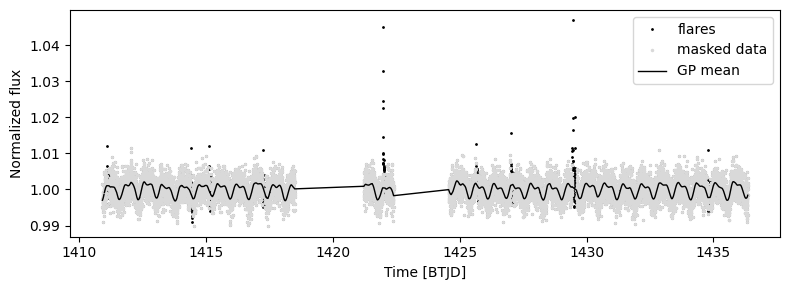

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(nu.time, nu.flux, ".", c="k", ms=2, label="flares")
plt.plot(nu_cleaned.time, nu_cleaned.flux, ".", c="0.85", ms=3, label="masked data")

gp_mean = nu_cleaned.mu(None)
split_idxs = [
    0,
    *np.flatnonzero(np.diff(time) > 10 / 60 / 24),
    len(time),
]

_ = True
for i in range(len(split_idxs) - 1):
    x = nu_cleaned.time[split_idxs[i] + 1 : split_idxs[i + 1]]
    y = gp_mean[split_idxs[i] + 1 : split_idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if _ else None, lw=1)
    _ = False

plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized flux")
plt.legend()
plt.tight_layout()

## Transit search

All the above is data preparation, now is time to actually search the cleaned light curve

### Linear search

In [6]:
t0s = time.copy()
durations = np.linspace(10 / 60 / 24, 2 / 24, 8)

gp = build_gp(gp_params, time)
nu = Nuance(time, flux, gp=gp)
nu.linear_search(t0s, durations)

  0%|          | 0/1215 [00:00<?, ?it/s]

### Periodic search

In [7]:
periods = np.linspace(0.5, 5, 10000)
search = nu.periodic_search(periods)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Result

We can retrieve the best (maximum-SNR) transit parameters with

In [8]:
t0, D, P = search.best
snr = nu.snr(t0, D, P)
depth, depth_error = nu.depth(t0, D, P)

print(f"Period: {P:.4f} days\nSNR: {snr:.2f}\nDepth: {depth:.2e} +- {depth_error:.2e}")

Period: 1.2390 days
SNR: 8.51
Depth: 1.80e-03 +- 2.12e-04


and plot the periodogram and phase-folded light curve with

Text(0.0, 1.0, 'Phase-folded detrended light curve')

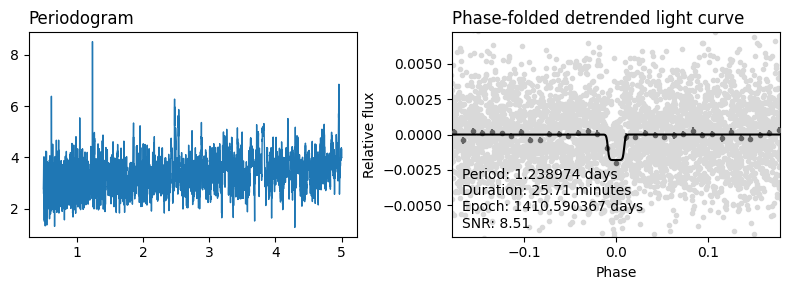

In [9]:
from nuance.utils import phase, binn_time

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(periods, search.Q_snr, lw=1)
plt.title("Periodogram", loc="left")

plt.subplot(122)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.time, t0, P)

detrended = nu.flux - noise - mean
plt.plot(phi, detrended, ".", c=".85")
bx, by, be = binn_time(phi, detrended, bins=15 / 60 / 24)
plt.errorbar(bx, by, yerr=be, fmt=".", c="0.4", zorder=10)
plt.xlim(*(np.array([-1, 1]) * 10 * D))
plt.ylim(*(np.array([-1, 1]) * float(np.abs(astro.min())) * 4))
_ = np.argsort(phi)
plt.plot(phi[_], astro[_], c="k", zorder=20)
plt.xlabel("Phase")
plt.ylabel("Relative flux")
plt.text(
    0.03,
    0.03,
    f"Period: {P:.6f} days\nDuration: {D* 24 * 60:.2f} minutes\nEpoch: {t0:.6f} days\nSNR: {snr:.2f}",
    ha="left",
    va="bottom",
    transform=plt.gca().transAxes,
)
plt.tight_layout()
plt.title("Phase-folded detrended light curve", loc="left")